### Downsample specsim output to log-10 A wavelength grid for eBOSS

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import specsim.simulator

In [3]:
simulator = specsim.simulator.Simulator('eboss', num_fibers=1)
simulator.atmosphere
#simulator.instrument.fast_fiber_acceptance
simulator.simulate()

blue_output = simulator.camera_output[0]
red_output = simulator.camera_output[1]

sim = simulator.simulated

b_wlen, r_wlen = blue_output['wavelength'], red_output['wavelength']
b_flux, r_flux = blue_output['observed_flux'], red_output['observed_flux']

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


25000 70501
5000 35001


In [4]:
import os
import astropy
import scipy

In [5]:
self_wavelength = np.arange(3000.0, 10050.1, 0.1) * astropy.units.Unit('Angstrom')

In [11]:
config = specsim.config.load_config('eboss')

In [12]:
cameras = config.instrument.cameras
camera = getattr(cameras, 'r')
config.load_table(camera.throughput, 'throughput')

array([0.        , 0.        , 0.        , ..., 0.11142972, 0.11140147,
       0.11137322])

Issue seems to be with `config.load_table()`.

In [13]:
abs_base_path = '/Users/belaabolfathi/desi/code/specsim/specsim/data/'

In [14]:
parent = camera.throughput
node = parent.table
column_names = ['throughput']

In [15]:
required_names = column_names[:]

In [16]:
required_names.append('wavelength')
required_names = sorted(required_names)

In [17]:
columns = node.columns
config_column_names = sorted(columns.keys())

In [18]:
read_args = {}
keys = node.keys()

In [19]:
paths = []
path_keys = None
paths.append(os.path.join(abs_base_path, node.path))

In [20]:
tables = {}
for i, path in enumerate(paths):
    key = path_keys[i] if path_keys else 'default'
    
    with warnings.catch_warnings():
                warnings.simplefilter(
                    'ignore', category=astropy.units.core.UnitsWarning)
                table = astropy.table.Table.read(path, **read_args)

    ## Line 419
    print('Loaded {0} rows from {1} with args {2}'
              .format(len(table), path, read_args))
    
    loaded_columns = {}
    for config_name in config_column_names:
        column = getattr(columns, config_name)
        #print(column)
        column_data = table[column.name]
        #print(column_data)
        column_values = column_data.data
        try:
            column_unit = astropy.units.Unit(column.unit)
        except AttributeError:
                    column_unit = None
        try:
            override_unit = column.override_unit
            assert override_unit in (True, False)
        except AttributeError:
            override_unit = False

        if override_unit or column_data.unit is None:
            if column_unit is not None:
                # Assign the unit specified in our config.
                column_data.unit = column_unit
        else:
            if ((column_unit is not None) and
                (column_unit != column_data.unit)):
                raise RuntimeError(
                    'Units do not match for "{0}".'.format(column))
        loaded_columns[config_name] = column_data
    wavelength_column = loaded_columns['wavelength']
    wavelength = wavelength_column.data * wavelength_column.unit
    try:
        fill_value = node.extrapolated_value
        bounds_error = False
    except AttributeError:
        fill_value = None
        bounds_error = True
    
    print(loaded_columns)
    # Loop over other columns to interpolate onto our
    # wavelength grid.
    '''for column_name in column_names:
        interpolator = scipy.interpolate.interp1d(
            wavelength.value, loaded_columns[column_name].data,
            kind='linear', copy=False,
            bounds_error=bounds_error, fill_value=fill_value)
        interpolated_values = interpolator(self_wavelength.value)
        unit = loaded_columns[column_name].unit
        if unit:
            interpolated_values = interpolated_values * unit
        loaded_columns[column_name] = interpolated_values
        '''
#print(loaded_columns)

Loaded 1001 rows from /Users/belaabolfathi/desi/code/specsim/specsim/data/sdss/eboss-thru-r.fits with args {}
{'throughput': <Column name='throughput' dtype='float64' length=1001>
0.0006651951075309871
0.0007229431315360761
0.0007869195071038338
0.0008574811789817899
0.0009451128198459081
0.0010388740541794385
0.0011585358918163532
 0.001305980482656054
 0.001477806491526785
0.0016820998316783833
 0.001936282272349631
0.0022322127527134557
                  ...
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852
 0.019029216543042852, 'wavelength': <Column name='wavelength' dtype='int64' unit='Angstrom' length=1001>
 5500
 5510
 5520
 5530
 5540
 5550
 5560
 5570
 5580
 5590
 5600
 5610
  ...
10988
10989
10990
10991
10992
10993
10994
10995
10996
10997
10998
10999}


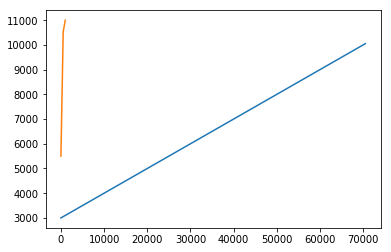

In [21]:
plt.plot(self_wavelength)
plt.plot(wavelength.value)
plt.show()

In [22]:
len(wavelength)

1001

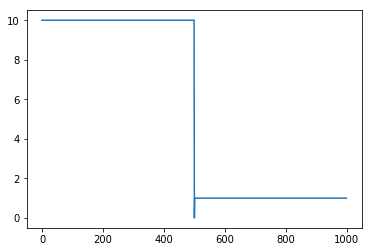

In [23]:
plt.plot(np.diff(wavelength))
plt.show()

In [24]:
column_name = 'throughput'

In [33]:
interpolator = scipy.interpolate.interp1d(
            wavelength.value, loaded_columns[column_name].data,
            kind='linear', copy=False,
            bounds_error=bounds_error, fill_value=fill_value)
interpolated_values = interpolator(self_wavelength.value)

In [34]:
len(wavelength)

1001

In [35]:
len(loaded_columns['throughput']), len(interpolated_values)

(1001, 70501)

In [36]:
bounds_error, fill_value

(False, 0.0)

In [37]:
len(self_wavelength.value)

70501

In [38]:
interpolated_values

array([0.        , 0.        , 0.        , ..., 0.11142972, 0.11140147,
       0.11137322])

In [39]:
np.where(interpolated_values != 0)[0]

array([25001, 25002, 25003, ..., 70498, 70499, 70500])

In [40]:
interpolated_values

array([0.        , 0.        , 0.        , ..., 0.11142972, 0.11140147,
       0.11137322])

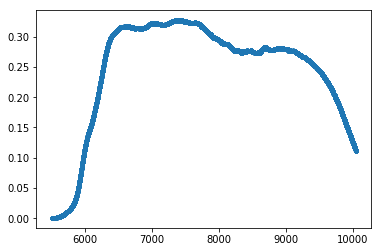

In [31]:
plt.plot(self_wavelength, interpolated_values, '.')
plt.show()

Check to see if throughput is nonzero where first element of row size is nonzero:

In [32]:
## Camera object
len(simulator.instrument.cameras[1]._row_size)

70501

In [33]:
np.where(simulator.instrument.cameras[0]._row_size > 0)[0]

array([  109,   110,   111, ..., 41367, 41368, 41369])

In [99]:
len(interpolated_values[109:25001]

array([0., 0., 0., ..., 0., 0., 0.])

In [106]:
np.diff(red_output['wavelength'])[0]

0.5

In [107]:
np.diff(astropy.table.Table.read(abs_base_path+'sdss/eboss-red.fits', format='fits')['wavelength'])[0]

1.399021635601457

### End of debugging -- everything below stays in nb

In [4]:
eboss_wlen = np.load('b_loglam.npy')

### Test cases for resampled functions (sanity check)

In [5]:
def resample_binned(edges_out, edges_in, hist_in, axis=-1, zero_pad=True):
    """Flux conserving linear resampler of binned data.
    Parameters
    ----------
    edges_out : array
        1D array of M >= 2 output bin edges, in increasing order.
    edges_in : array
        1D array of N >= 2 input bin edges, in increasing order.
    hist_in : array
        Array with N-1 input bin values indexed by the specified axis.
    axis : int
        Axis of hist_in used to index input histogram values.
    zero_pad : bool
        When True, allow the output edges to extend beyond the input
        edges and assume that the input histogram is zero outside of
        its extent.  When False, raises a ValueError if extrapolation
        would be required.
    Returns
    -------
    array
        1D array of M-1 resampled bin values.
    """
    # Check input 1D arrays.
    edges_out = np.asarray(edges_out)
    edges_in = np.asarray(edges_in)
    if edges_out.ndim != 1:
        raise ValueError('Expected 1D edges_out.')
    if edges_in.ndim != 1:
        raise ValueError('Expected 1D edges_in.')
    if len(edges_out) < 2:
        raise ValueError('Need at least one output bin.')
    if len(edges_in) < 2:
        raise ValueError('Need at least one input bin.')
    binsize_out = np.diff(edges_out)
    if np.any(binsize_out <= 0):
        raise ValueError('Expecting increasing edges_out.')
    binsize_in = np.diff(edges_in)
    if np.any(binsize_in <= 0):
        raise ValueError('Expecting increasing edges_in.')
    if not zero_pad and ((edges_out[0] < edges_in[0]) or
                         (edges_out[-1] > edges_in[-1])):
        raise ValueError(
            'Ouput bins extend beyond input bins but zero_pad is False.')
    if (edges_out[0] >= edges_in[-1]) or (edges_out[-1] <= edges_in[0]):
        raise ValueError('Input and output bins do not overlap.')
    # Check input histogram(s) and put index in axis 0. Note that we
    # use moveaxis instead of rollaxis since it is easier to invert.
    hist_in = np.asarray(hist_in)
    hist_in_rolled = np.moveaxis(hist_in, axis, 0)
    if len(hist_in_rolled) != len(edges_in) - 1:
        raise ValueError(
            'Unexpected length of hist_in along axis {}.'.format(axis))
    # Align output edges to input edges.
    idx = np.searchsorted(edges_in, edges_out)
    # Loop over output bins.
    nin = len(edges_in) - 1
    nout = len(edges_out) - 1
    hist_out_rolled_shape = (nout,) + hist_in_rolled.shape[1:]
    hist_out_rolled = np.zeros(hist_out_rolled_shape)
    hi = idx[0]
    for i in range(nout):
        lo = hi
        hi = idx[i + 1]
        if (lo > nin) or (hi == 0):
            # This bin does not overlap the input.
            continue
        if lo == hi:
            # Output bin is fully embedded within an input bin:
            # give it a linear share.
            hist_out_rolled[i] = (
                binsize_out[i] / binsize_in[lo - 1] * hist_in_rolled[lo - 1])
            continue
        # Calculate fraction of first input bin overlapping this output bin.
        if lo > 0:
            hist_out_rolled[i] += (
                hist_in_rolled[lo - 1] / binsize_in[lo - 1] * (
                    edges_in[lo] - edges_out[i]))
        # Calculate fraction of last input bin overlaping this output bin.
        if hi <= nin:
            hist_out_rolled[i] += (
                hist_in_rolled[hi - 1] / binsize_in[hi - 1] * (
                    edges_out[i + 1] - edges_in[hi - 1]))
        # Add input bins fully contained within this output bin.
        if hi > lo + 1:
            hist_out_rolled[i] += np.sum(hist_in_rolled[lo:hi - 1], axis=0)
    # Return our unrolled output histogram.
    return np.moveaxis(hist_out_rolled, axis, 0)

In [34]:
dat = np.random.normal(loc=0, scale=1.0, size=100)
edges_in = np.arange(-3,4,1)
hist_in, _ = np.histogram(dat, edges_in)
edges_out = np.arange(-3,4,2)

In [35]:
hist_out = resample_binned(edges_out, edges_in, hist_in)

In [40]:
mdpt_in = 0.5 * (edges_in[1:] + edges_in[:-1])

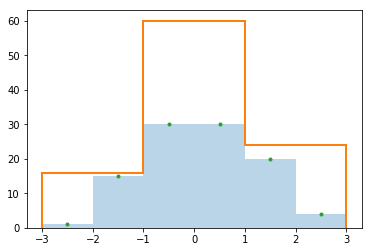

In [46]:
plt.hist(dat, bins=edges_in, alpha=0.3)
plt.hist(dat, bins=edges_out, histtype='step', lw=2)
plt.plot(mdpt_in, hist_in, '.')
plt.show()

Good - works as we would expect. Now I want to write my own downsampling function, do it the long way first so that I understand each step of what is going on. After this I will verify that I get the same result using `skysim.utils.resample_density()` then `skysim.utils.resample_binned()`. 

The first thing we need to do is to convert from flux density to counts. We do this by multiplying the flux by the bin width. Create `b_edges` so that the midpoint of each bin is centered on the values `b_wlen`.

Note: some of the `b_flux` and `r_flux` values are nan's ... need to look into this (maybe has to do with how throughput is calculated for wavelength values that fall outside of the wavelength grid for each camera?)

In [4]:
## Bin width
b_diff = np.diff(b_wlen)
print(np.all(b_diff[0] == b_diff))
b_diff = b_diff[0]

True


In [5]:
## Define nominal bin edges
b_edges = b_wlen - (0.5 * b_diff)
b_edges = np.append(b_edges, b_edges[-1] + b_diff)
b_edges = np.log10(b_edges)

#### ** NEED TO FIX NAN ISSUE **

In [6]:
#b_flux[np.isnan(b_flux)] = 0.0

In [7]:
b_counts = b_flux * b_diff
## b_counts, b_edges is our simulation histogram

In [24]:
## Define eBOSS bin edges
eboss_wlen = np.load('b_loglam.npy')
eboss_diff = np.diff(eboss_wlen)
eboss_diff_app = np.append(eboss_diff, eboss_diff[-1])
eboss_edges = eboss_wlen - (0.5 * eboss_diff_app)
eboss_edges = np.append(eboss_edges, eboss_edges[-1] + eboss_diff_app[-1])

In [25]:
idx_in_eboss = np.searchsorted(eboss_edges, b_edges)

In [26]:
output_hist = np.zeros_like(eboss_wlen)
flux_right = 0
prev_idx = -1

for i in range(len(idx_in_eboss) - 1):
    if np.isnan(output_hist[idx_in_eboss[i]]):
        print(i)
    output_hist[idx_in_eboss[i] - 1] += flux_right
    if prev_idx == idx_in_eboss[i+1]:
        output_hist[prev_idx - 1] += b_counts[i]
    else:
        diff = idx_in_eboss[i+1] - idx_in_eboss[i]
        if diff == 0:
            output_hist[idx_in_eboss[i] - 1] += b_counts[i]
            flux_right = 0
            prev_idx = idx_in_eboss[i]
        elif diff > 0:
            left = (eboss_edges[idx_in_eboss[i]] - b_edges[i]) / (b_edges[i+1] - b_edges[i])
            right = 1 - left
            flux_left = left * b_counts[i]
            flux_right = right * b_counts[i]
            #assert (flux_right + flux_left) == b_counts[i]
            output_hist[idx_in_eboss[i] - 1] += flux_left

In [27]:
assert np.allclose(np.sum(output_hist), np.sum(b_counts))

In [14]:
fs = 14

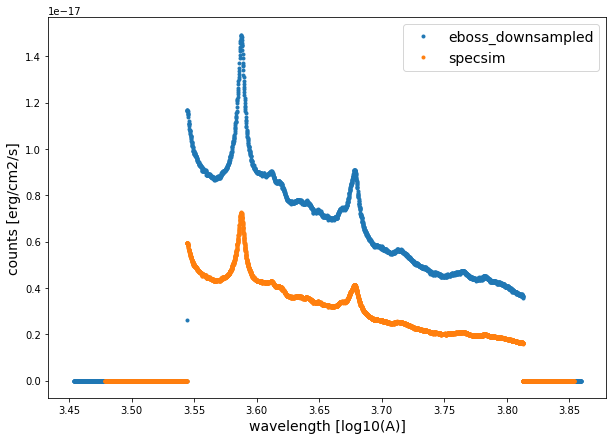

In [29]:
plt.figure(figsize=(10,7))
plt.plot(eboss_wlen, output_hist, '.', label='eboss_downsampled')
plt.plot(np.log10(b_wlen), b_counts, '.', label='specsim')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('counts [erg/cm2/s]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

Makes sense that it conserves flux even though it has higher counts at each wavelength because the wavelength grid is more sparse for the downsampled curve (specsim is more densely sampled).

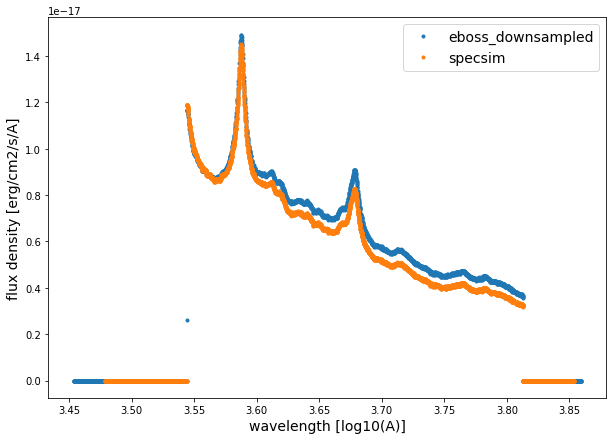

In [30]:
plt.figure(figsize=(10,7))
plt.plot(eboss_wlen, output_hist / (10 ** np.diff(eboss_edges)), '.', label='eboss_downsampled')
plt.plot(np.log10(b_wlen), b_flux, '.', label='specsim')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

### Wrap everything into a single function

In [102]:
def downsample_to_eboss(wavelength_out, wavelength_in, flux_in):
    
    ## Get nominal bin width
    diff_in = np.diff(wavelength_in)
    ## Check that nominal grid is equally spaced 
    assert np.allclose(diff_in[0], diff_in, atol=0.0, rtol=1e-5)
    diff_in = diff_in[0]
    
    ## Define nominal bin edges
    edges_in = wavelength_in - (0.5 * diff_in)
    edges_in = np.append(edges_in, edges_in[-1] + diff_in)
    edges_in = np.log10(edges_in)
    
    ## Define output bin edges
    diff_out = np.diff(wavelength_out)
    diff_out = np.append(diff_out, diff_out[-1])
    edges_out = wavelength_out - (0.5 * diff_out)
    edges_out = np.append(edges_out, edges_out[-1] + diff_out[-1])
    #edges_out = edges_out[::10]
    
    
    ## Check that both grids are strictly increasing
    assert np.all(edges_out == np.sort(edges_out))
    assert np.all(edges_in == np.sort(edges_in))
    ## Check that output grid covers the range of input grid 
    ## This is a necessary condition for flux conservation.
    assert edges_out[0] < edges_in[0]
    assert edges_out[-1] > edges_in[-1]
    
    ## Find index in out_edges where each element in in_edges 
    ## would fall in out_edges
    idx_in_out = np.searchsorted(edges_out, edges_in)
        
    ## Convert from flux density (per unit Angstrom) to flux (counts)
    ## First set nan elements to zero - this is temporary. Need to fix this.
    flux_in[np.isnan(flux_in)] = 0.0
    hist_in = flux_in * diff_in
    
    
    hist_out = np.zeros(len(edges_out) - 1)
    flux_right = 0
    prev_idx = -1

    for i in range(len(idx_in_out) - 1):
        if np.isnan(hist_out[idx_in_out[i]]):
            print(i)
        hist_out[idx_in_out[i] - 1] += flux_right
        if prev_idx == idx_in_out[i+1]:
            hist_out[prev_idx - 1] += hist_in[i]
        else:
            diff = idx_in_out[i+1] - idx_in_out[i]
            if diff == 0:
                hist_out[idx_in_out[i] - 1] += hist_in[i]
                flux_right = 0
                prev_idx = idx_in_out[i]
            elif diff > 0:
                left = (edges_out[idx_in_out[i]] - edges_in[i]) / (edges_in[i+1] - edges_in[i])
                right = 1 - left
                flux_left = left * hist_in[i]
                flux_right = right * hist_in[i]
                assert np.allclose((flux_right + flux_left), hist_in[i])
                hist_out[idx_in_out[i] - 1] += flux_left

    ## Check if flux is conserved
    assert np.allclose(np.sum(hist_out), np.sum(hist_in))
    #return(hist_out, edges_out)
    
    ## Convert back from counts to flux density
    flux_out = hist_out / (np.diff(10 ** edges_out))
    ## Only return values within range of simulation wavelength grid
    start = idx_in_out[0]
    stop = idx_in_out[-1]
    return(edges_out[start:stop], flux_out[start:stop-1])

In [485]:
test_eboss_counts, test_eboss_grid = downsample_to_eboss(eboss_wlen, b_wlen, b_flux)
np.all(test_eboss_counts == output_hist), np.all(test_eboss_grid == eboss_edges)

(True, True)

In [141]:
test_eboss_edges, test_eboss_flux = downsample_to_eboss(eboss_wlen, b_wlen, b_flux)
np.all(test_eboss_flux == output_hist / (np.diff(10 ** eboss_edges)))

True

In [103]:
eboss_r_wlen = np.load('r_loglam.npy')
eboss_r_edges, eboss_r_flux = downsample_to_eboss(eboss_r_wlen, r_wlen, r_flux)

In [104]:
eboss_b_wlen = np.load('b_loglam.npy')
eboss_b_edges, eboss_b_flux = downsample_to_eboss(eboss_b_wlen, b_wlen, b_flux)

In [105]:
r_mdpt = 0.5 * (eboss_r_edges[1:] + eboss_r_edges[:-1])

In [106]:
b_mdpt = 0.5 * (eboss_b_edges[1:] + eboss_b_edges[:-1])

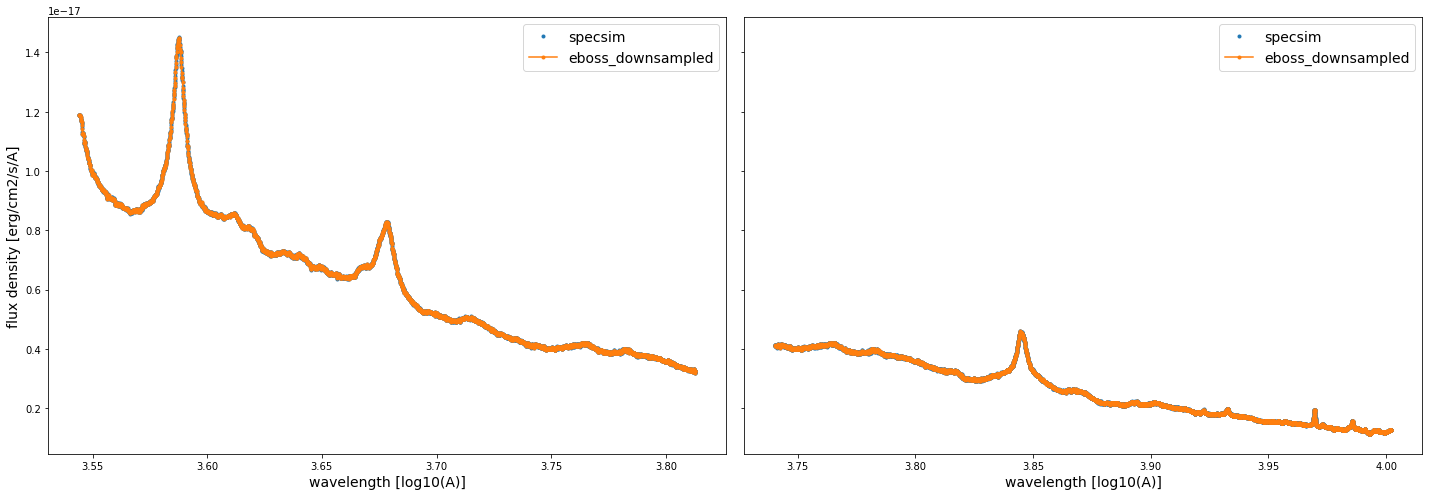

In [107]:
fig, axs = plt.subplots(1,2, figsize=(20,7), sharey=True)
axs = axs.ravel()

axs[0].plot(np.log10(b_wlen), b_flux, '.', label='specsim')
axs[0].plot(b_mdpt, eboss_b_flux, '.-', label='eboss_downsampled')
axs[0].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[0].set_ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
axs[0].legend(fontsize=fs)

axs[1].plot(np.log10(r_wlen), r_flux, '.', label='specsim')
axs[1].plot(r_mdpt, eboss_r_flux, '.-', label='eboss_downsampled')
axs[1].set_xlabel('wavelength [log10(A)]', fontsize=fs)
axs[1].legend(fontsize=fs)

plt.tight_layout()
plt.show()

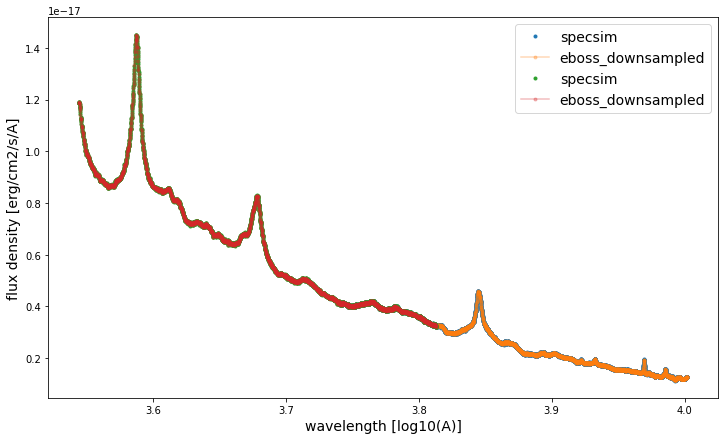

In [109]:
plt.figure(figsize=(12,7))
plt.plot(np.log10(r_wlen), r_flux, '.', label='specsim')
plt.plot(r_mdpt, eboss_r_flux, '.-', alpha=0.3, label='eboss_downsampled')
plt.plot(np.log10(b_wlen), b_flux, '.', label='specsim')
plt.plot(b_mdpt, eboss_b_flux, '.-', alpha=0.3, label='eboss_downsampled')
plt.xlabel('wavelength [log10(A)]', fontsize=fs)
plt.ylabel('flux density [erg/cm2/s/A]', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()